In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import time
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

In [10]:
# === PATHS ===
SCRIPT_PATH = os.getcwd()
DATA_DIR = os.path.abspath(os.path.join(SCRIPT_PATH, '..', '..', 'data', 'preprocessed', 'analysis_data'))
MODELS_DIR = os.path.abspath(os.path.join(SCRIPT_PATH, '..', '..', 'models', 'naive_bayes'))
FEATURES_NAMES_DIR = os.path.abspath(os.path.join(DATA_DIR,'feature_names.pkl'))
os.makedirs(MODELS_DIR, exist_ok=True)

In [11]:
# === LOAD DATA ===
train_path = os.path.join(DATA_DIR, 'train.csv')
test_path = os.path.join(DATA_DIR, 'test.csv')

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [12]:
target_col = 'Fault_Condition'
feature_cols = joblib.load(FEATURES_NAMES_DIR)

X_train = train_data[feature_cols]
y_train_raw = train_data[target_col]
X_test = test_data[feature_cols]
y_test_raw = test_data[target_col]

le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)
print("Mapowanie klas:", dict(zip(le.classes_, le.transform(le.classes_))))

print(f"Features count: {len(feature_cols)}")
print(f"Training samples count: {len(X_train)}")

Mapowanie klas: {'faulty': np.int64(0), 'faulty_zip': np.int64(1), 'healthy': np.int64(2), 'healthy_zip': np.int64(3)}
Features count: 26
Training samples count: 128


In [13]:
# === TRAINING AND OPTIMIZATION ===
param_grid = {'var_smoothing': np.logspace(0, -9, num=100)}

gnb = GaussianNB()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

start_time = time.time()
grid_search = GridSearchCV(gnb, param_grid, cv=cv, scoring='accuracy', n_jobs=1, verbose=1)
grid_search.fit(X_train, y_train)
elapsed_time = time.time() - start_time

best_model = grid_search.best_estimator_
print(f"Optimiaztion ended in {elapsed_time:.2f}s")
print(f"Best params: {grid_search.best_params_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Optimiaztion ended in 0.98s
Best params: {'var_smoothing': np.float64(0.003511191734215131)}


In [14]:
# === EVALUATION ON TRAIN SET ===
y_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)

print(f"\nAccuracy on test set: {test_acc:.4f}")
print("\nClassifications report:")
print(classification_report(y_test, y_pred))


Accuracy on test set: 0.9643

Classifications report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.93      1.00      0.97        14
           2       1.00      0.93      0.96        14
           3       0.93      1.00      0.97        14

    accuracy                           0.96        56
   macro avg       0.97      0.96      0.96        56
weighted avg       0.97      0.96      0.96        56



<Figure size 800x600 with 0 Axes>

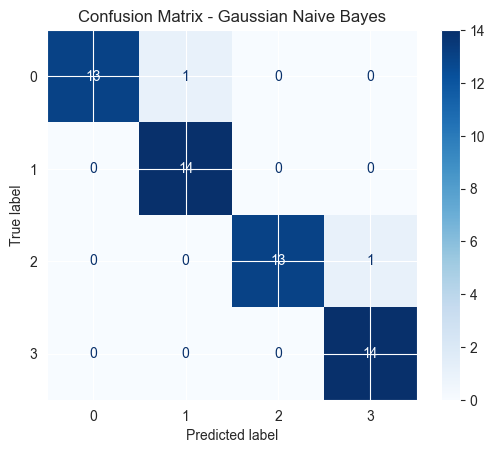

In [15]:
# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Gaussian Naive Bayes")
plt.show()

In [17]:
# === CROSS VALIDATION ===
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy')
print(f"\nAverage cross-validation score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# === SAVE MODEL ===
model_filename = 'gaussian_naive_bayes.pkl'
model_path = os.path.join(MODELS_DIR, model_filename)
joblib.dump(best_model, model_path)
print(f"\nModel saved in: {model_path}")

encoder_filename = 'label_encoder.pkl'
encoder_path = os.path.join(MODELS_DIR, encoder_filename)
joblib.dump(le, encoder_path)
print(f"Label Encoder saved to: {encoder_path}")


Average cross-validation score: 0.9212 (+/- 0.0501)

Model saved in: C:\Users\Jakub\Kuba_lokalne\studia\Praca_magisterska\Projekt\Fault-detection-in-mechanical-devices\models\naive_bayes\gaussian_naive_bayes.pkl
Label Encoder saved to: C:\Users\Jakub\Kuba_lokalne\studia\Praca_magisterska\Projekt\Fault-detection-in-mechanical-devices\models\naive_bayes\label_encoder.pkl
